In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor
from tweepy import Stream

from textblob import TextBlob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
ACCESS_TOKEN = "972856602377076736-9n9KJdQlm6RPlD8tLrTBOnT2wZRSdZU"
ACCESS_TOKEN_SECRET = "5mxCT0O3efmmHtmABpJH30BbzjhE1tZSUtvljUjuaCknG"
CONSUMER_KEY = "WdEkXvesactnxwzuTJlDRCQ2X"
CONSUMER_SECRET = "oK9bJkG7gF7PNKpM8t8mVAtYOl3YwNhfy5mkIB1PbOYnTdEyPZ"

In [3]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [4]:
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

In [5]:
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        pass

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = StdOutListener(fetched_tweets_filename)
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

In [6]:
# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """

    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="awscloud", count=200)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    print(df)

                                                tweets                   id  \
0    Complete #AWSDeepRacer weekly challenges for y...  1163213159416700929   
1    New #AWSLaunches!\n🚀AWS App Mesh now supports ...  1163204427718778882   
2    Find out how to build, secure &amp; manage you...  1163172215615033346   
3    Not sure which AWS data transfer tools are bes...  1163166606916300801   
4    Heading to #VMworld 2019 US? Check out our "Kn...  1163143775230844929   
5    Learn how to provide more fine-grained securit...  1163142771429036032   
6    Find out how you can provide centralized, colu...  1163125405634764801   
7    📊 Planning to run AWS infrastructure on-premis...  1163102513794625537   
8    In this episode of #ThisisMyArchitecture, Vale...  1163064572644929536   
9    In this installment of our enterprise strategi...  1163043881522479104   
10   Do you love learning something new every day &...  1163017659782447104   
11   Running Windows applications? You can now stor.

In [7]:
df.columns

Index(['tweets', 'id', 'len', 'date', 'source', 'likes', 'retweets',
       'sentiment'],
      dtype='object')

In [8]:
positive_count = df[df.sentiment == 1].count()
neutral_count = df[df.sentiment == 0].count()
negative_count = df[df.sentiment == -1].count()
print(positive_count["sentiment"])
print(negative_count["sentiment"])
print(neutral_count["sentiment"])

119
6
75


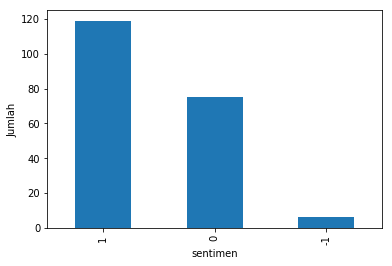

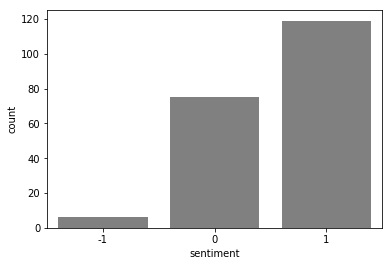

In [9]:
import seaborn as sns
df['sentiment'].value_counts().plot(kind='bar')
plt.xlabel("sentimen")
plt.ylabel("Jumlah")
plt.show()

sns.countplot(df['sentiment'], color='gray')

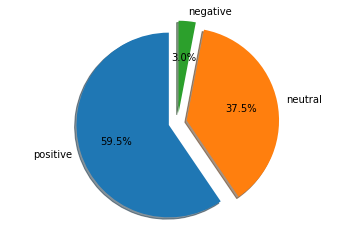

In [10]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'positive', 'neutral', 'negative'
sizes = [positive_count["sentiment"], neutral_count["sentiment"], negative_count["sentiment"]]
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
df.head()

,tweets,id,len,date,source,likes,retweets,sentiment
0,Complete #AWSDeepRacer weekly challenges for y...,1163213159416700929,140,2019-08-18 22:16:43,Sprinklr,12,4,1
1,New #AWSLaunches!\n🚀AWS App Mesh now supports ...,1163204427718778882,140,2019-08-18 21:42:01,Sprinklr,18,7,1
2,"Find out how to build, secure &amp; manage you...",1163172215615033346,137,2019-08-18 19:34:01,Sprinklr,24,11,1
3,Not sure which AWS data transfer tools are bes...,1163166606916300801,140,2019-08-18 19:11:44,Sprinklr,84,23,1
4,"Heading to #VMworld 2019 US? Check out our ""Kn...",1163143775230844929,140,2019-08-18 17:41:00,Sprinklr,21,11,1


In [12]:
df_log = df

In [13]:
#checking zeros value in retweets and likes 
retweets_zeros = df_log[df_log.retweets == 0].count()
likes_zeros = df_log[df_log.likes == 0].count()
print("Menentukan nilai dari variabel retweets dan likes yang nilai nya 0")
print("retweets =",retweets_zeros["retweets"])
print("likes =",likes_zeros["likes"])

Menentukan nilai dari variabel retweets dan likes yang nilai nya 0
retweets = 0
likes = 6


In [14]:
# Ambil indeks dari kolom likes yang nilai nya sama dengan nol
indexNames = df_log[ df_log['likes'] == 0 ].index
 
# Delete these row indexes from dataFrame
df_log.drop(indexNames , inplace=True)

In [15]:
df.head()

,tweets,id,len,date,source,likes,retweets,sentiment
0,Complete #AWSDeepRacer weekly challenges for y...,1163213159416700929,140,2019-08-18 22:16:43,Sprinklr,12,4,1
1,New #AWSLaunches!\n🚀AWS App Mesh now supports ...,1163204427718778882,140,2019-08-18 21:42:01,Sprinklr,18,7,1
2,"Find out how to build, secure &amp; manage you...",1163172215615033346,137,2019-08-18 19:34:01,Sprinklr,24,11,1
3,Not sure which AWS data transfer tools are bes...,1163166606916300801,140,2019-08-18 19:11:44,Sprinklr,84,23,1
4,"Heading to #VMworld 2019 US? Check out our ""Kn...",1163143775230844929,140,2019-08-18 17:41:00,Sprinklr,21,11,1


In [16]:
df_log.head()

,tweets,id,len,date,source,likes,retweets,sentiment
0,Complete #AWSDeepRacer weekly challenges for y...,1163213159416700929,140,2019-08-18 22:16:43,Sprinklr,12,4,1
1,New #AWSLaunches!\n🚀AWS App Mesh now supports ...,1163204427718778882,140,2019-08-18 21:42:01,Sprinklr,18,7,1
2,"Find out how to build, secure &amp; manage you...",1163172215615033346,137,2019-08-18 19:34:01,Sprinklr,24,11,1
3,Not sure which AWS data transfer tools are bes...,1163166606916300801,140,2019-08-18 19:11:44,Sprinklr,84,23,1
4,"Heading to #VMworld 2019 US? Check out our ""Kn...",1163143775230844929,140,2019-08-18 17:41:00,Sprinklr,21,11,1


In [17]:
#checking zeros value in retweets and likes 
retweets_zeros = df_log[df_log.retweets == 0].count()
likes_zeros = df_log[df_log.likes == 0].count()
print("Menentukan nilai dari variabel retweets dan likes yang nilai nya 0")
print("retweets =",retweets_zeros["retweets"])
print("likes =",likes_zeros["likes"])

Menentukan nilai dari variabel retweets dan likes yang nilai nya 0
retweets = 0
likes = 0


In [18]:
#Multiclass Logistic Classification
#Definisikan X sebagai retweets dan likes dan y sebagai sentiment
X = df.iloc[:, [5, 6]].values
y = df.iloc[:, 7].values

In [19]:
X

array([[ 12,   4],
       [ 18,   7],
       [ 24,  11],
       [ 84,  23],
       [ 21,  11],
       [ 39,  12],
       [ 24,  10],
       [ 41,  18],
       [ 57,  20],
       [ 23,   9],
       [ 62,  13],
       [ 41,  13],
       [ 51,  12],
       [ 33,   9],
       [ 29,   9],
       [ 47,  13],
       [ 24,  10],
       [ 42,  18],
       [ 20,   7],
       [ 27,  11],
       [ 21,  10],
       [ 17,  11],
       [156,  40],
       [ 73,  27],
       [ 39,  18],
       [ 41,  14],
       [ 27,  12],
       [ 24,  20],
       [170,  27],
       [ 24,  13],
       [ 28,  14],
       [ 25,   9],
       [ 30,   8],
       [ 32,   9],
       [ 49,  22],
       [ 19,   8],
       [ 23,   9],
       [ 41,  13],
       [ 28,  15],
       [ 23,   6],
       [ 19,   7],
       [ 17,   9],
       [ 24,   7],
       [ 21,   8],
       [ 37,  12],
       [ 27,   9],
       [ 43,  16],
       [ 25,   7],
       [ 24,   7],
       [ 48,  18],
       [ 63,  24],
       [ 23,   9],
       [ 38,

In [20]:
y

array([ 1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  1,  0,  1,  1,  1,  0,  0,
        0,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1, -1,  0,  1,  1,  0,  0,
        0,  1,  1,  0,  1,  1,  1,  1,  1,  0,  1,  0, -1,  0,  1,  1,  0,
        1,  1,  1,  1,  1,  1,  0,  1,  0,  0,  1,  1,  1,  1,  0,  1,  1,
        0,  1,  1,  1,  1,  1,  1, -1,  1,  1,  0,  0,  1,  0,  1,  0,  1,
        0,  0,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  1, -1,  1,
        1,  1,  1,  1,  0,  1,  0,  0,  0,  0, -1,  1,  1,  1,  1,  0,  1,
        1,  0,  1,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,  1,  1,  0,
        0,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1,  1,  0,  1,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  0,  0,  1,  1,
        0,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  0,  1, -1,  1,  0,  0,
        1,  1,  1,  0,  1,  1,  0])

In [39]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 34)

In [40]:
# Feature Scaling to bring the variable in a single scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\RIZIQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\RIZIQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\RIZIQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [41]:
# Fitting Multiclass Logistic Classification to the Training set
from sklearn.linear_model import LogisticRegression
logisticregression = LogisticRegression()
logisticregression.fit(X_train, y_train)

C:\Users\RIZIQ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RIZIQ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
# Predicting the Test set results
y_pred = logisticregression.predict(X_test)
print(y_pred)

[ 1  0  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  0  1  1  1  1  1  0  1  1  1]


In [43]:
#lets see the actual and predicted value side by side
y_compare = np.vstack((y_test,y_pred)).T
#actual value on the left side and predicted value on the right hand side
#printing the top 5 values
y_compare[:5,:]

array([[1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1]])

In [44]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  0  1]
 [ 1  2 10]
 [ 0  1 24]]


In [45]:
logisticregression.intercept_, logisticregression.coef_

(array([-3.0164065 , -0.50228366,  0.37035431]),
 array([[ 6.03412901e-01, -2.77521037e-01],
        [ 1.47471569e-04,  1.31766412e-01],
        [-3.10367793e-01,  4.39721253e-02]]))

In [46]:
#finding accuracy from the confusion matrix.
a = cm.shape
corrPred = 0
falsePred = 0

for row in range(a[0]):
    for c in range(a[1]):
        if row == c:
            corrPred +=cm[row,c]
        else:
            falsePred += cm[row,c]
print('Correct predictions: ', corrPred)
print('False predictions', falsePred)
print ('Accuracy of the multiclass logistic classification is: ', corrPred/(cm.sum()))

Correct predictions:  26
False predictions 13
Accuracy of the multiclass logistic classification is:  0.6666666666666666
